In [4]:
# pip install geopandas

In [5]:
# pip install folium

In [6]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon
from shapely import wkt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from transformers import pipeline
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

## Data Load/Clean

In [7]:
crime_df = pd.read_csv('data/Police_Department_Incident_Reports__Historical_2016_to_May_2018.csv')
crime_df.head()

,PdId,IncidntNum,Incident Code,Category,Descript,DayOfWeek,Date,Time,PdDistrict,Resolution,Address,X,Y,location
0,16072741510045,160727415,10045,EMBEZZLEMENT,"EMBEZZLEMENT, GRAND THEFT BY EMPLOYEE",Friday,01/01/2016,00:01,INGLESIDE,NONE,5700 Block of MISSION ST,-122.450297,37.709552,POINT (-122.45029719777277 37.70955194084215)
1,16600299606372,166002996,6372,LARCENY/THEFT,PETTY THEFT OF PROPERTY,Friday,01/01/2016,13:40,CENTRAL,NONE,JEFFERSON ST / MASON ST,-122.414167,37.808420,POINT (-122.41416651509333 37.808419917270975)
2,17015398506304,170153985,6304,LARCENY/THEFT,GRAND THEFT FROM A BUILDING,Friday,01/01/2016,00:01,BAYVIEW,NONE,100 Block of APOLLO ST,-122.398745,37.730854,POINT (-122.3987447553861 37.730854021807374)
3,16063185010015,160631850,10015,EMBEZZLEMENT,"EMBEZZLEMENT, GRAND THEFT",Friday,01/01/2016,12:00,BAYVIEW,NONE,4000 Block of 3RD ST,-122.388753,37.740736,POINT (-122.38875304699722 37.74073605483584)
4,16020260575030,160202605,75030,NON-CRIMINAL,CASE CLOSURE,Friday,01/01/2016,12:00,CENTRAL,UNFOUNDED,2700 Block of HYDE ST,-122.420535,37.806189,POINT (-122.4205346782714 37.8061892244521)


In [8]:
crime_df['Date'] = pd.to_datetime(crime_df['Date'])

In [9]:
crime_df.dtypes

PdId                      int64
IncidntNum                int64
Incident Code             int64
Category                 object
Descript                 object
DayOfWeek                object
Date             datetime64[ns]
Time                     object
PdDistrict               object
Resolution               object
Address                  object
X                       float64
Y                       float64
location                 object
dtype: object

In [10]:
crime_df = crime_df.drop(columns=['PdId', 'IncidntNum', 'Incident Code', 'Address', 'location'])

In [11]:
crime_df.columns

Index(['Category', 'Descript', 'DayOfWeek', 'Date', 'Time', 'PdDistrict',
       'Resolution', 'X', 'Y'],
      dtype='object')

In [12]:
crime_df.shape

(345979, 9)

In [13]:
neighb_df = pd.read_csv('data/sf_neighbourhoods.csv')

In [14]:
neighb_df.head()

,LINK,the_geom,name
0,"http://en.wikipedia.org/wiki/Sea_Cliff,_San_Fr...",MULTIPOLYGON (((-122.49345526799993 37.7835181...,Seacliff
1,NaN,MULTIPOLYGON (((-122.48715071499993 37.7837854...,Lake Street
2,http://www.nps.gov/prsf/index.htm,MULTIPOLYGON (((-122.47758017099994 37.8109931...,Presidio National Park
3,NaN,MULTIPOLYGON (((-122.47241052999993 37.7873465...,Presidio Terrace
4,http://www.sfgate.com/neighborhoods/sf/innerri...,MULTIPOLYGON (((-122.47262578999994 37.7863148...,Inner Richmond


In [15]:
neighb_df.shape

(117, 3)

### Geo Coordinates Classification

In [16]:
geom = [Point(xy) for xy in zip(crime_df['X'], crime_df['Y'])]
crime_geo = gpd.GeoDataFrame(crime_df, geometry=geom)
crime_geo.head()

,Category,Descript,DayOfWeek,Date,Time,PdDistrict,Resolution,X,Y,geometry
0,EMBEZZLEMENT,"EMBEZZLEMENT, GRAND THEFT BY EMPLOYEE",Friday,2016-01-01,00:01,INGLESIDE,NONE,-122.450297,37.709552,POINT (-122.45030 37.70955)
1,LARCENY/THEFT,PETTY THEFT OF PROPERTY,Friday,2016-01-01,13:40,CENTRAL,NONE,-122.414167,37.808420,POINT (-122.41417 37.80842)
2,LARCENY/THEFT,GRAND THEFT FROM A BUILDING,Friday,2016-01-01,00:01,BAYVIEW,NONE,-122.398745,37.730854,POINT (-122.39874 37.73085)
3,EMBEZZLEMENT,"EMBEZZLEMENT, GRAND THEFT",Friday,2016-01-01,12:00,BAYVIEW,NONE,-122.388753,37.740736,POINT (-122.38875 37.74074)
4,NON-CRIMINAL,CASE CLOSURE,Friday,2016-01-01,12:00,CENTRAL,UNFOUNDED,-122.420535,37.806189,POINT (-122.42053 37.80619)


In [17]:
neighb_df['geometry'] = neighb_df['the_geom'].apply(wkt.loads)
neighb_geo = gpd.GeoDataFrame(neighb_df)
neighb_geo.head()

,LINK,the_geom,name,geometry
0,"http://en.wikipedia.org/wiki/Sea_Cliff,_San_Fr...",MULTIPOLYGON (((-122.49345526799993 37.7835181...,Seacliff,"MULTIPOLYGON (((-122.49346 37.78352, -122.4937..."
1,NaN,MULTIPOLYGON (((-122.48715071499993 37.7837854...,Lake Street,"MULTIPOLYGON (((-122.48715 37.78379, -122.4872..."
2,http://www.nps.gov/prsf/index.htm,MULTIPOLYGON (((-122.47758017099994 37.8109931...,Presidio National Park,"MULTIPOLYGON (((-122.47758 37.81099, -122.4771..."
3,NaN,MULTIPOLYGON (((-122.47241052999993 37.7873465...,Presidio Terrace,"MULTIPOLYGON (((-122.47241 37.78735, -122.4710..."
4,http://www.sfgate.com/neighborhoods/sf/innerri...,MULTIPOLYGON (((-122.47262578999994 37.7863148...,Inner Richmond,"MULTIPOLYGON (((-122.47263 37.78631, -122.4668..."


In [18]:
crime_geo['neighbourhood'] = None

In [19]:
crime_geo.head(2)

,Category,Descript,DayOfWeek,Date,Time,PdDistrict,Resolution,X,Y,geometry,neighbourhood
0,EMBEZZLEMENT,"EMBEZZLEMENT, GRAND THEFT BY EMPLOYEE",Friday,2016-01-01,00:01,INGLESIDE,NONE,-122.450297,37.709552,POINT (-122.45030 37.70955),None
1,LARCENY/THEFT,PETTY THEFT OF PROPERTY,Friday,2016-01-01,13:40,CENTRAL,NONE,-122.414167,37.808420,POINT (-122.41417 37.80842),None


In [20]:
crime_geo.loc[crime_geo.intersects(neighb_geo.loc[0, 'geometry']), 'neighbourhood'] = neighb_geo['name'].loc[0]

In [21]:
%%time
for i in range(len(neighb_geo)):
    crime_geo.loc[crime_geo.intersects(neighb_geo.loc[i, 'geometry']), 'neighbourhood'] = neighb_geo['name'].loc[i]

CPU times: user 4min 17s, sys: 5.72 s, total: 4min 22s
Wall time: 6min 17s


In [22]:
crime_geo['neighbourhood'].isna().sum() / len(crime_geo) #The percentage of missing data is minimal, so it is okay to drop it

0.002601313952580937

In [23]:
crime_geo.dropna(inplace=True)

In [24]:
crime_geo.describe()

,X,Y
count,345079.000000,345079.000000
mean,-122.423619,37.769161
std,0.026103,0.023539
min,-122.513642,37.708154
25%,-122.433623,37.756624
50%,-122.417105,37.775421
75%,-122.406691,37.785094
max,-122.365241,37.819975


In [25]:
crime_geo

,Category,Descript,DayOfWeek,Date,Time,PdDistrict,Resolution,X,Y,geometry,neighbourhood
0,EMBEZZLEMENT,"EMBEZZLEMENT, GRAND THEFT BY EMPLOYEE",Friday,2016-01-01,00:01,INGLESIDE,NONE,-122.450297,37.709552,POINT (-122.45030 37.70955),Crocker Amazon
1,LARCENY/THEFT,PETTY THEFT OF PROPERTY,Friday,2016-01-01,13:40,CENTRAL,NONE,-122.414167,37.808420,POINT (-122.41417 37.80842),Fishermans Wharf
2,LARCENY/THEFT,GRAND THEFT FROM A BUILDING,Friday,2016-01-01,00:01,BAYVIEW,NONE,-122.398745,37.730854,POINT (-122.39874 37.73085),Silver Terrace
3,EMBEZZLEMENT,"EMBEZZLEMENT, GRAND THEFT",Friday,2016-01-01,12:00,BAYVIEW,NONE,-122.388753,37.740736,POINT (-122.38875 37.74074),Bayview
4,NON-CRIMINAL,CASE CLOSURE,Friday,2016-01-01,12:00,CENTRAL,UNFOUNDED,-122.420535,37.806189,POINT (-122.42053 37.80619),Aquatic Park / Ft. Mason
...,...,...,...,...,...,...,...,...,...,...,...
345974,NON-CRIMINAL,"AIDED CASE, MENTAL DISTURBED",Tuesday,2018-05-15,04:14,SOUTHERN,NONE,-122.419258,37.775146,POINT (-122.41926 37.77515),South of Market
345975,DRUG/NARCOTIC,POSSESSION OF NARCOTICS PARAPHERNALIA,Tuesday,2018-05-15,01:25,SOUTHERN,"ARREST, BOOKED",-122.410042,37.781954,POINT (-122.41004 37.78195),South of Market
345976,ROBBERY,"ROBBERY, BODILY FORCE",Tuesday,2018-05-15,01:25,SOUTHERN,"ARREST, BOOKED",-122.410042,37.781954,POINT (-122.41004 37.78195),South of Market
345977,LIQUOR LAWS,MISCELLANEOUS LIQOUR LAW VIOLATION,Tuesday,2018-05-15,00:19,PARK,"ARREST, BOOKED",-122.447761,37.769846,POINT (-122.44776 37.76985),Haight Ashbury


In [26]:
crime_geo.copy().to_csv('./data/combined_data_set.csv')

### Data Cleaning

In [60]:
df = pd.read_csv('./data/combined_data_set.csv')

---
# ********DELETE****************

In [28]:
# df['Date'] = pd.to_datetime(df['Date'])
# df['Month'] = df['Date'].dt.month
# df['Day'] = df['Date'].dt.day
# df['Year'] = df['Date'].dt.year

In [29]:
# # Parts of day split between ranges below:
# #     morning = 6am - 11:59pm (6,11)
# #     aftrenoon = 12pm - 5:59pm (12, 17)
# #     evening = 6pm - 10:59pm (18, 22)
# #     overnight = 11pm - 5:59am (0, 5)
# train['Morning'] = train['Dates'].dt.hour.between(6, 11).astype(int)
# train['Afternoon'] = train['Dates'].dt.hour.between(12, 17).astype(int)
# train['Evening'] = train['Dates'].dt.hour.between(18, 22).astype(int)
# train['Overnight'] = (
#     (train['Dates'].dt.hour == 23) | \
#     (train['Dates'].dt.hour.between(0, 5)) \
#     ).astype(int)

In [30]:
# df['Time'] = pd.to_datetime(df['Time'])

In [31]:
# df['Hour'] = df['Time'].dt.hour

In [32]:
# df['Category'].value_counts()

In [33]:
# plt.figure(figsvalue_counts))
# sns.histplot(data=df, x='Hour', hue='Category')

# ************************************
---

In [61]:
df['Date'] = pd.to_datetime(df['Date'])
df['Time'] = pd.to_datetime(df['Time'])
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day
df['Year'] = df['Date'].dt.year
df['Hour'] = df['Time'].dt.hour

In [62]:
# Parts of day split between ranges below:
#     morning = 6am - 11:59pm (6,11)
#     aftrenoon = 12pm - 5:59pm (12, 17)
#     evening = 6pm - 10:59pm (18, 22)
#     overnight = 11pm - 5:59am (0, 5)

df['Morning'] = df['Time'].dt.hour.between(6, 11).astype(int)
df['Afternoon'] = df['Time'].dt.hour.between(12, 17).astype(int)
df['Evening'] = df['Time'].dt.hour.between(18, 22).astype(int)
df['Overnight'] = (
    (df['Time'].dt.hour == 23) | \
    (df['Time'].dt.hour.between(0, 5)) \
    ).astype(int)

In [63]:
# Drop columns due to multicollinearity
df.drop(columns='Date', inplace=True)
df.drop(columns='Time', inplace=True)

In [64]:
# Drop row containint the category 'TREA' as there are only four occurences, or 0.0012% of total data.
df = df[df['Category'] != 'TREA']

In [65]:
# Drop rows where 'Category' is 'Other Offenses' or 'Recovered Vehicle'
df = df[(df["Category"] != 'OTHER OFFENSES')]
df = df[(df["Category"] != 'RECOVERED VEHICLE')]

In [66]:
# Defining target categories
target = {
    'other': ['SUICIDE', 'DISORDERLY CONDUCT', 'DRUG/NARCOTIC', 'DRUNKENNESS', 'FRAUD', 'EMBEZZLEMENT',
             'BRIBERY', 'EXTORTION', 'GAMBLING', 'BAD CHECKS', 'FORGERY/COUNTERFEITING', 'KIDNAPPING',
             'SEX OFFENSES, NON FORCIBLE', 'SEX OFFENSES, FORCIBLE', 'FAMILY OFFENSES', 'SECONDARY CODES',
             'NON-CRIMINAL'],
    'police': ['PROSTITUTION', 'ASSAULT', 'ARSON', 'WEAPON LAWS', 'DRIVING UNDER THE INFLUENCE', 'ROBBERY'],
    'police_non_urgent': ['LARCENY/THEFT', 'VEHICLE THEFT', 'STOLEN PROPERTY', 'SUSPICIOUS OCC',
                         'VANDALISM', 'PORNOGRAPHY/OBSCENE MAT', 'LOITERING', 'MISSING PERSON',
                         'BURGLARY', 'TRESPASS', 'WARRANTS',  'LIQUOR LAWS']
}

# Mapping 'Target' column from 'Categories' column
#
# The code below was taken from user ALollz's response to question at the following link:
# https://stackoverflow.com/questions/64320960/pandas-create-a-column-by-mapping-from-a-dict-of-lists

target_map = {val:key for key, lst in target.items() for val in lst}
df['Target'] = df['Category'].map(target_map)

In [67]:
# Changing 'Target' column to 'other' where 'Category' is 'Prostitution' AND 'Descript' contains any of
#     the following words: ['trafficking', 'pimping', 'underage']
#
# Inspiration for the following code was taken from user cs95's response to the question at the link below:
# https://stackoverflow.com/questions/47937697/scalable-solution-for-str-contains-with-list-of-strings-in-pandas

prostitution_flags = ['trafficking', 'pimping', 'underage']
flag = '|'.join(prostitution_flags)
mask = df.loc[:, ('Descript')].str.lower().str.contains(flag)
df.at[mask,'Target'] = 'other'

In [68]:
# Changing 'Target' column to 'police_non_urgent' where 'Category' is 'PROSTITUTION' AND 'DESCRIPT' contains any of
#     the following words: ['civil', 'investigation']
non_crim_flags = ['civil', 'investigation']
flag = '|'.join(non_crim_flags)
mask = df.loc[:, ('Descript')].str.lower().str.contains(flag)
df.at[mask,'Target'] = 'police_non_urgent'

In [69]:
df.head()

,Unnamed: 0,Category,Descript,DayOfWeek,PdDistrict,Resolution,X,Y,geometry,neighbourhood,Month,Day,Year,Hour,Morning,Afternoon,Evening,Overnight,Target
0,0,EMBEZZLEMENT,"EMBEZZLEMENT, GRAND THEFT BY EMPLOYEE",Friday,INGLESIDE,NONE,-122.450297,37.709552,POINT (-122.4502971977728 37.70955194084215),Crocker Amazon,1,1,2016,0,0,0,0,1,other
1,1,LARCENY/THEFT,PETTY THEFT OF PROPERTY,Friday,CENTRAL,NONE,-122.414167,37.808420,POINT (-122.4141665150933 37.80841991727097),Fishermans Wharf,1,1,2016,13,0,1,0,0,police_non_urgent
2,2,LARCENY/THEFT,GRAND THEFT FROM A BUILDING,Friday,BAYVIEW,NONE,-122.398745,37.730854,POINT (-122.3987447553861 37.73085402180737),Silver Terrace,1,1,2016,0,0,0,0,1,police_non_urgent
3,3,EMBEZZLEMENT,"EMBEZZLEMENT, GRAND THEFT",Friday,BAYVIEW,NONE,-122.388753,37.740736,POINT (-122.3887530469972 37.74073605483584),Bayview,1,1,2016,12,0,1,0,0,other
4,4,NON-CRIMINAL,CASE CLOSURE,Friday,CENTRAL,UNFOUNDED,-122.420535,37.806189,POINT (-122.4205346782714 37.8061892244521),Aquatic Park / Ft. Mason,1,1,2016,12,0,1,0,0,other


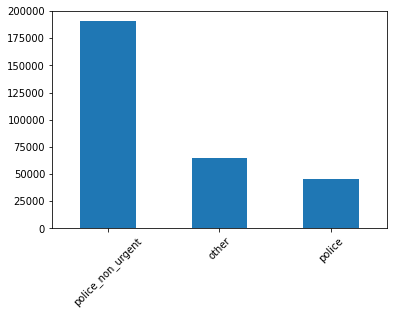

In [70]:
df['Target'].value_counts().plot(kind='bar')
plt.xticks(rotation=45);

### Try to subcategorize the 'other' category, time permitting

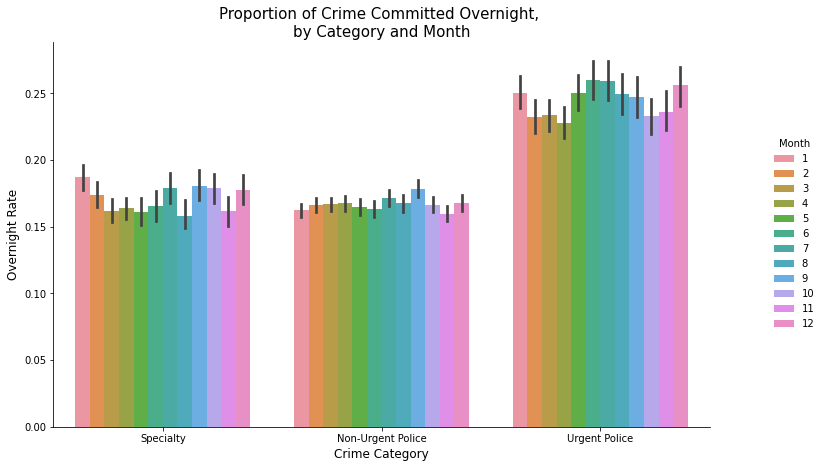

In [154]:
g = sns.catplot(x="Target", y="Overnight", hue="Month", kind="bar", data=df)
g.fig.set_figwidth(12)
g.fig.set_figheight(6)
plt.xticks(ticks=[0,1,2], labels=['Specialty', 'Non-Urgent Police', 'Urgent Police'])
plt.xlabel('Crime Category', fontsize=12)
plt.ylabel('Overnight Rate', fontsize=12)
plt.title('Proportion of Crime Committed Overnight, \nby Category and Month', fontsize=15);

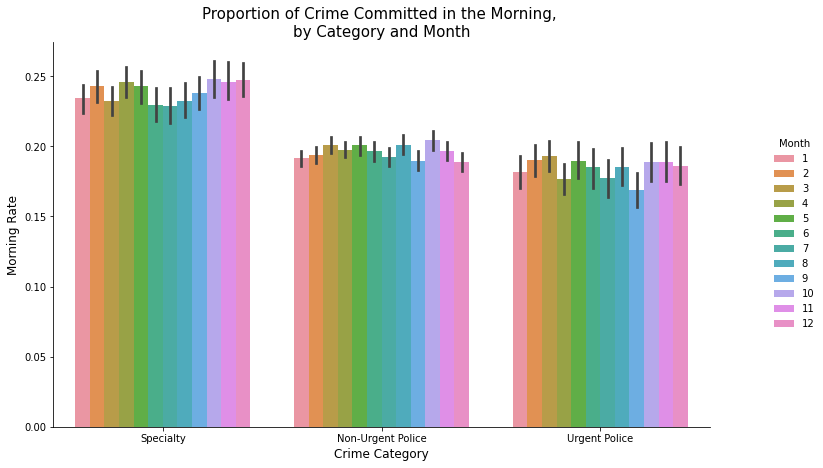

In [155]:
g = sns.catplot(x="Target", y="Morning", hue="Month", kind="bar", data=df)
g.fig.set_figwidth(12)
g.fig.set_figheight(6)
plt.xticks(ticks=[0,1,2], labels=['Specialty', 'Non-Urgent Police', 'Urgent Police'])
plt.xlabel('Crime Category', fontsize=12)
plt.ylabel('Morning Rate', fontsize=12)
plt.title('Proportion of Crime Committed in the Morning, \nby Category and Month', fontsize=15);

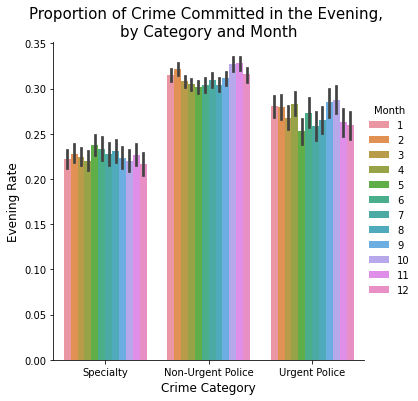

In [156]:
sns.catplot(x="Target", y="Evening", hue="Month", kind="bar", data=df)
plt.xticks(ticks=[0,1,2], labels=['Specialty', 'Non-Urgent Police', 'Urgent Police'])
plt.xlabel('Crime Category', fontsize=12)
plt.ylabel('Evening Rate', fontsize=12)
plt.title('Proportion of Crime Committed in the Evening, \nby Category and Month', fontsize=15);

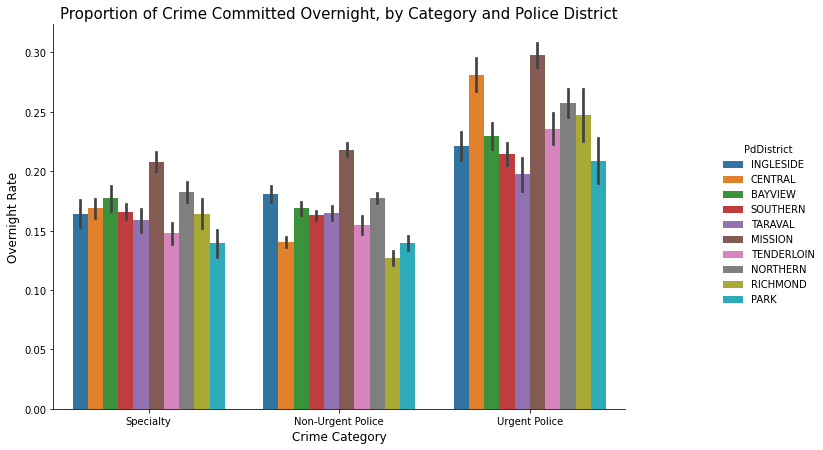

In [157]:
g = sns.catplot(x="Target", y="Overnight", hue="PdDistrict", kind="bar", data=df);
g.fig.set_figwidth(12)
g.fig.set_figheight(6)
plt.xticks(ticks=[0,1,2], labels=['Specialty', 'Non-Urgent Police', 'Urgent Police'])
plt.xlabel('Crime Category', fontsize=12)
plt.ylabel('Overnight Rate', fontsize=12)
plt.title('Proportion of Crime Committed Overnight, by Category and Police District', fontsize=15);

In [146]:
df.head()

,Unnamed: 0,Category,Descript,DayOfWeek,PdDistrict,Resolution,X,Y,geometry,neighbourhood,Month,Day,Year,Hour,Morning,Afternoon,Evening,Overnight,Target
0,0,EMBEZZLEMENT,"EMBEZZLEMENT, GRAND THEFT BY EMPLOYEE",Friday,INGLESIDE,NONE,-122.450297,37.709552,POINT (-122.4502971977728 37.70955194084215),Crocker Amazon,1,1,2016,0,0,0,0,1,other
1,1,LARCENY/THEFT,PETTY THEFT OF PROPERTY,Friday,CENTRAL,NONE,-122.414167,37.808420,POINT (-122.4141665150933 37.80841991727097),Fishermans Wharf,1,1,2016,13,0,1,0,0,police_non_urgent
2,2,LARCENY/THEFT,GRAND THEFT FROM A BUILDING,Friday,BAYVIEW,NONE,-122.398745,37.730854,POINT (-122.3987447553861 37.73085402180737),Silver Terrace,1,1,2016,0,0,0,0,1,police_non_urgent
3,3,EMBEZZLEMENT,"EMBEZZLEMENT, GRAND THEFT",Friday,BAYVIEW,NONE,-122.388753,37.740736,POINT (-122.3887530469972 37.74073605483584),Bayview,1,1,2016,12,0,1,0,0,other
4,4,NON-CRIMINAL,CASE CLOSURE,Friday,CENTRAL,UNFOUNDED,-122.420535,37.806189,POINT (-122.4205346782714 37.8061892244521),Aquatic Park / Ft. Mason,1,1,2016,12,0,1,0,0,other


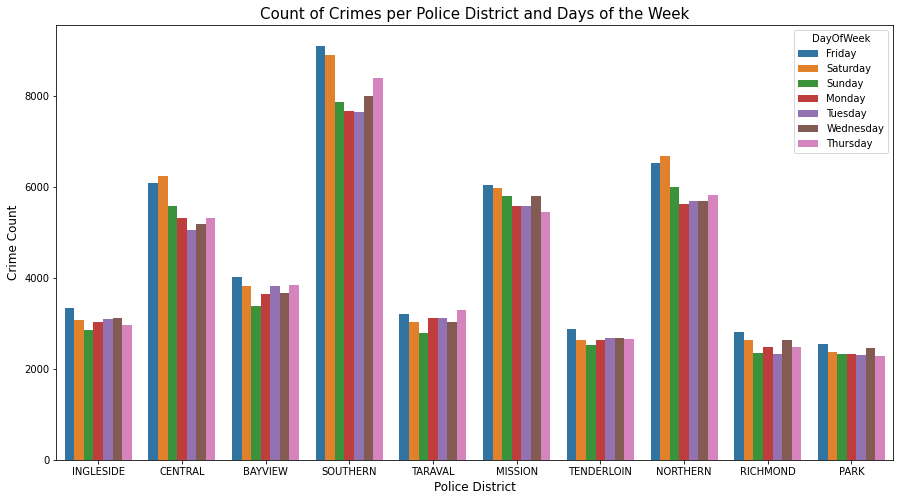

In [151]:
fig_size = (15, 8)
fig, ax = plt.subplots(figsize=fig_size)
sns.countplot(x="PdDistrict", hue="DayOfWeek", data=df);
plt.xlabel('Police District', fontsize=12)
plt.ylabel('Crime Count', fontsize=12)
plt.title('Count of Crimes per Police District and Days of the Week', fontsize=15);

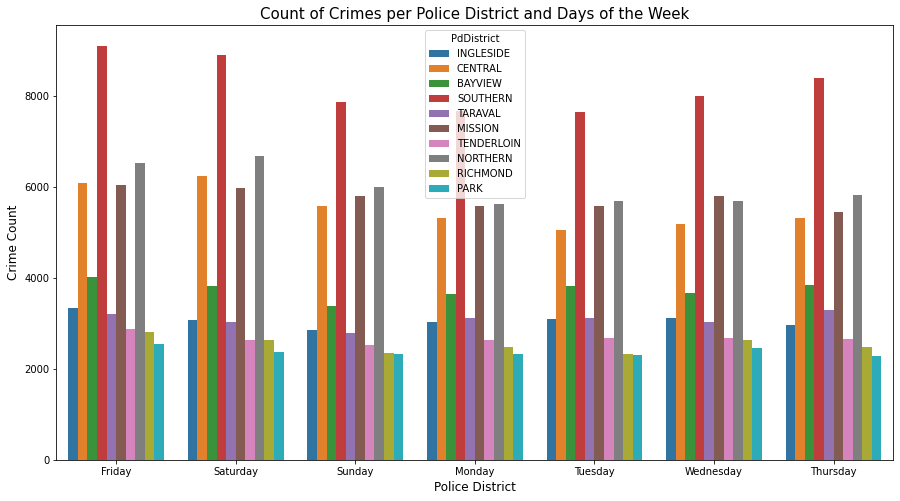

In [158]:
fig_size = (15, 8)
fig, ax = plt.subplots(figsize=fig_size)
sns.countplot(x="DayOfWeek", hue="PdDistrict", data=df);
plt.xlabel('Police District', fontsize=12)
plt.ylabel('Crime Count', fontsize=12)
plt.title('Count of Crimes per Police District and Days of the Week', fontsize=15);

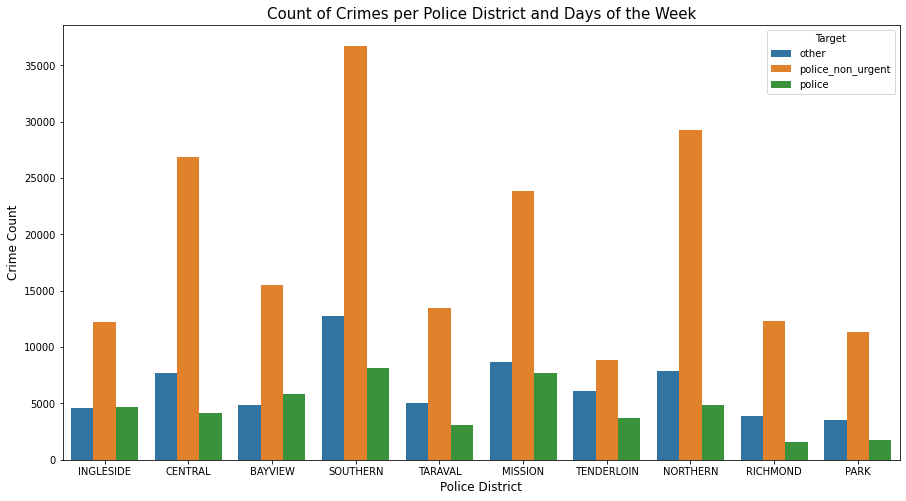

In [152]:
fig_size = (15, 8)
fig, ax = plt.subplots(figsize=fig_size)
sns.countplot(x="PdDistrict", hue="Target", data=df);
plt.xlabel('Police District', fontsize=12)
plt.ylabel('Crime Count', fontsize=12)
plt.title('Count of Crimes per Police District and Days of the Week', fontsize=15);

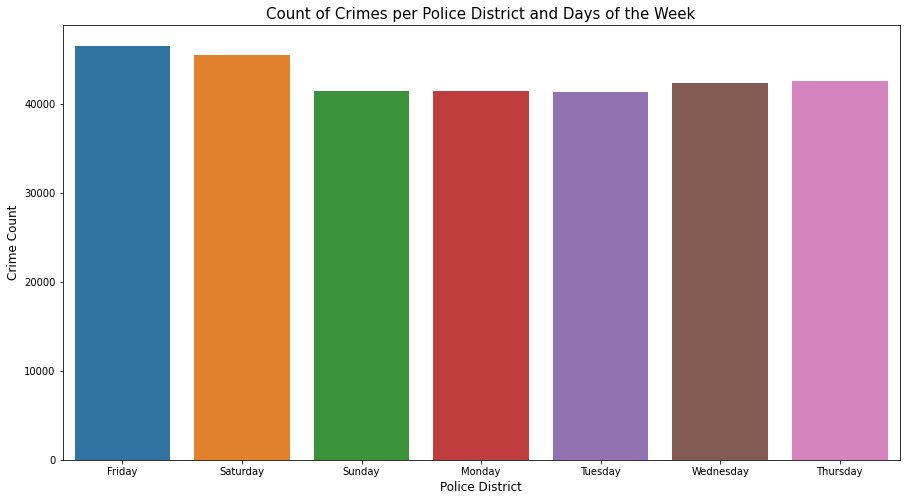

In [165]:
fig_size = (15, 8)
fig, ax = plt.subplots(figsize=fig_size)
sns.countplot(x="DayOfWeek", data=df);
plt.xlabel('Police District', fontsize=12)
plt.ylabel('Crime Count', fontsize=12)
plt.title('Count of Crimes per Police District and Days of the Week', fontsize=15);

In [161]:
df.head()

,Unnamed: 0,Category,Descript,DayOfWeek,PdDistrict,Resolution,X,Y,geometry,neighbourhood,Month,Day,Year,Hour,Morning,Afternoon,Evening,Overnight,Target
0,0,EMBEZZLEMENT,"EMBEZZLEMENT, GRAND THEFT BY EMPLOYEE",Friday,INGLESIDE,NONE,-122.450297,37.709552,POINT (-122.4502971977728 37.70955194084215),Crocker Amazon,1,1,2016,0,0,0,0,1,other
1,1,LARCENY/THEFT,PETTY THEFT OF PROPERTY,Friday,CENTRAL,NONE,-122.414167,37.808420,POINT (-122.4141665150933 37.80841991727097),Fishermans Wharf,1,1,2016,13,0,1,0,0,police_non_urgent
2,2,LARCENY/THEFT,GRAND THEFT FROM A BUILDING,Friday,BAYVIEW,NONE,-122.398745,37.730854,POINT (-122.3987447553861 37.73085402180737),Silver Terrace,1,1,2016,0,0,0,0,1,police_non_urgent
3,3,EMBEZZLEMENT,"EMBEZZLEMENT, GRAND THEFT",Friday,BAYVIEW,NONE,-122.388753,37.740736,POINT (-122.3887530469972 37.74073605483584),Bayview,1,1,2016,12,0,1,0,0,other
4,4,NON-CRIMINAL,CASE CLOSURE,Friday,CENTRAL,UNFOUNDED,-122.420535,37.806189,POINT (-122.4205346782714 37.8061892244521),Aquatic Park / Ft. Mason,1,1,2016,12,0,1,0,0,other


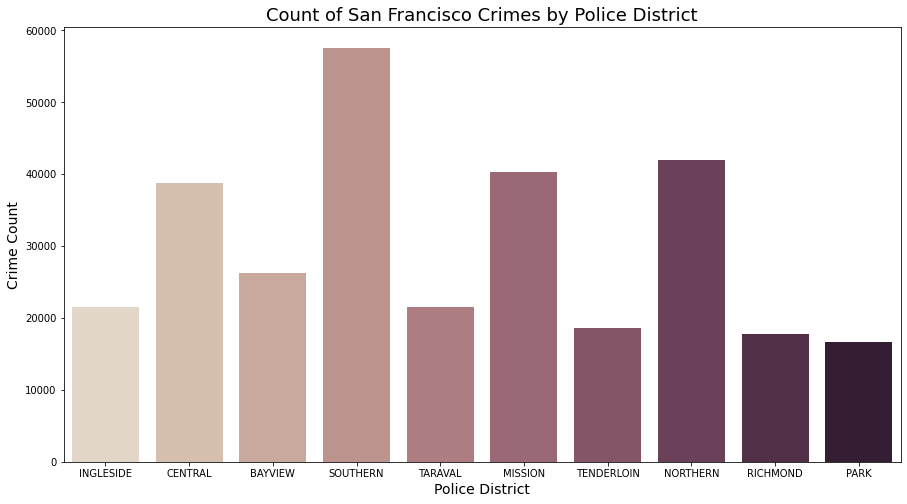

In [122]:
fig_size = (15, 8)
fig, ax = plt.subplots(figsize=fig_size)
sns.countplot(x="PdDistrict", palette="ch:.25", data=df, ax=ax)
plt.xlabel('Police District', fontsize=14)
plt.ylabel('Crime Count', fontsize=14)
plt.title('Count of San Francisco Crimes by Police District', fontsize=18);

In [168]:
df.head()

,Unnamed: 0,Category,Descript,DayOfWeek,PdDistrict,Resolution,X,Y,geometry,neighbourhood,Month,Day,Year,Hour,Morning,Afternoon,Evening,Overnight,Target
0,0,EMBEZZLEMENT,"EMBEZZLEMENT, GRAND THEFT BY EMPLOYEE",Friday,INGLESIDE,NONE,-122.450297,37.709552,POINT (-122.4502971977728 37.70955194084215),Crocker Amazon,1,1,2016,0,0,0,0,1,other
1,1,LARCENY/THEFT,PETTY THEFT OF PROPERTY,Friday,CENTRAL,NONE,-122.414167,37.808420,POINT (-122.4141665150933 37.80841991727097),Fishermans Wharf,1,1,2016,13,0,1,0,0,police_non_urgent
2,2,LARCENY/THEFT,GRAND THEFT FROM A BUILDING,Friday,BAYVIEW,NONE,-122.398745,37.730854,POINT (-122.3987447553861 37.73085402180737),Silver Terrace,1,1,2016,0,0,0,0,1,police_non_urgent
3,3,EMBEZZLEMENT,"EMBEZZLEMENT, GRAND THEFT",Friday,BAYVIEW,NONE,-122.388753,37.740736,POINT (-122.3887530469972 37.74073605483584),Bayview,1,1,2016,12,0,1,0,0,other
4,4,NON-CRIMINAL,CASE CLOSURE,Friday,CENTRAL,UNFOUNDED,-122.420535,37.806189,POINT (-122.4205346782714 37.8061892244521),Aquatic Park / Ft. Mason,1,1,2016,12,0,1,0,0,other


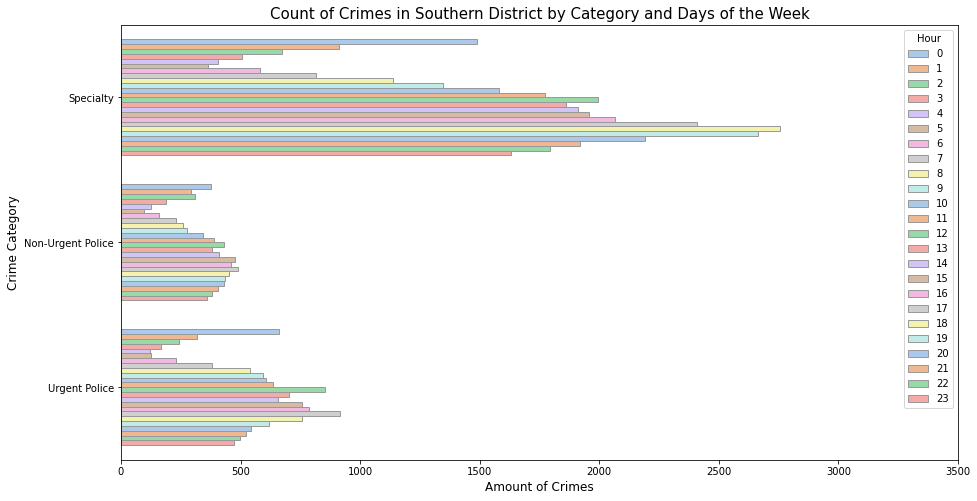

In [180]:
fig, ax = plt.subplots(figsize=fig_size)
sns.countplot(y="Target", hue="Hour",
            palette="pastel", edgecolor=".6",
            data=df[df['PdDistrict'] == 'SOUTHERN'], ax=ax)
plt.xlim([0, 3500])
plt.yticks(ticks=[0,1,2], labels=['Specialty', 'Non-Urgent Police', 'Urgent Police'])
plt.xlabel('Amount of Crimes', fontsize=12)
plt.ylabel('Crime Category', fontsize=12)
plt.title('Count of Crimes in Southern District by Category and Days of the Week', fontsize=15);

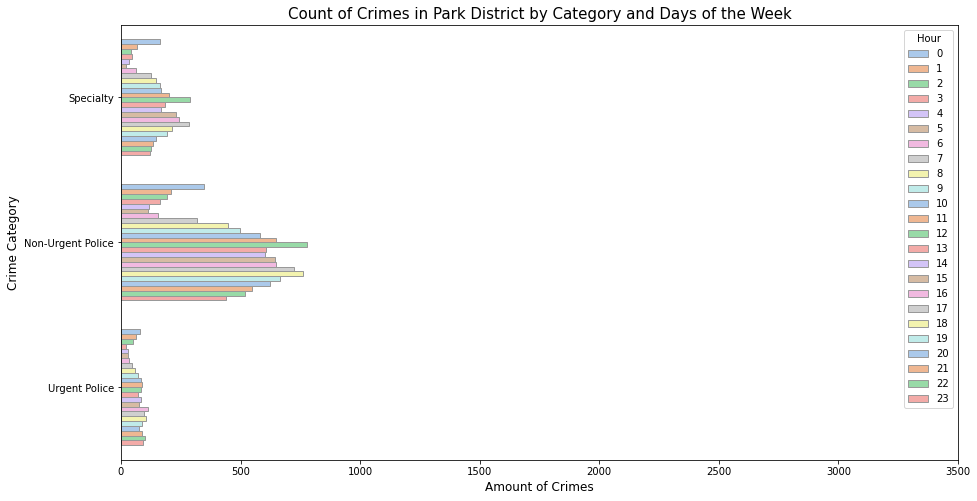

In [179]:
fig, ax = plt.subplots(figsize=fig_size)
sns.countplot(y="Target", hue="Hour",
            palette="pastel", edgecolor=".6",
            data=df[df['PdDistrict'] == 'PARK'], ax=ax)
plt.xlim([0, 3500])
plt.yticks(ticks=[0,1,2], labels=['Specialty', 'Non-Urgent Police', 'Urgent Police'])
plt.xlabel('Amount of Crimes', fontsize=12)
plt.ylabel('Crime Category', fontsize=12)
plt.title('Count of Crimes in Park District by Category and Days of the Week', fontsize=15);

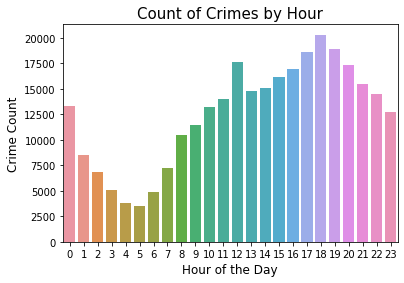

In [128]:
sns.countplot(x=df['Hour'])
plt.xlabel('Hour of the Day', fontsize=12)
plt.ylabel('Crime Count', fontsize=12)
plt.title('Count of Crimes by Hour', fontsize=15);

In [79]:
len(df['neighbourhood'].value_counts())

116

In [137]:
df.head()

,Unnamed: 0,Category,Descript,DayOfWeek,PdDistrict,Resolution,X,Y,geometry,neighbourhood,Month,Day,Year,Hour,Morning,Afternoon,Evening,Overnight,Target
0,0,EMBEZZLEMENT,"EMBEZZLEMENT, GRAND THEFT BY EMPLOYEE",Friday,INGLESIDE,NONE,-122.450297,37.709552,POINT (-122.4502971977728 37.70955194084215),Crocker Amazon,1,1,2016,0,0,0,0,1,other
1,1,LARCENY/THEFT,PETTY THEFT OF PROPERTY,Friday,CENTRAL,NONE,-122.414167,37.808420,POINT (-122.4141665150933 37.80841991727097),Fishermans Wharf,1,1,2016,13,0,1,0,0,police_non_urgent
2,2,LARCENY/THEFT,GRAND THEFT FROM A BUILDING,Friday,BAYVIEW,NONE,-122.398745,37.730854,POINT (-122.3987447553861 37.73085402180737),Silver Terrace,1,1,2016,0,0,0,0,1,police_non_urgent
3,3,EMBEZZLEMENT,"EMBEZZLEMENT, GRAND THEFT",Friday,BAYVIEW,NONE,-122.388753,37.740736,POINT (-122.3887530469972 37.74073605483584),Bayview,1,1,2016,12,0,1,0,0,other
4,4,NON-CRIMINAL,CASE CLOSURE,Friday,CENTRAL,UNFOUNDED,-122.420535,37.806189,POINT (-122.4205346782714 37.8061892244521),Aquatic Park / Ft. Mason,1,1,2016,12,0,1,0,0,other


## Preprocessing

##### Instantiating X, y

In [311]:
drops = ['Category', 'Descript', 'Resolution', 'Morning', 'Afternoon', 'Evening',
         'Overnight', 'Target', 'geometry', 'PdDistrict', 'X', 'Y']
# drops = ['Category', 'Descript', 'Resolution', 'Target', 'geometry']

X = df.drop(columns=drops)
X = pd.get_dummies(data=X, drop_first=True)
y = df['Target']

# Label Enconding taken from user Luca Massaron's response to the question at the link below:
# https://stackoverflow.com/questions/50201315/is-numerical-encoding-necessary-for-the-target-variable-in-classification
label_encoder = LabelEncoder().fit(y)
y = label_encoder.transform(y)

rand_st = 1920

#### Train/Test Split

In [312]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.3,
    stratify=y,
    random_state=rand_st
)

#### Scaling Features

In [313]:
ss =StandardScaler()
Z_train = ss.fit_transform(X_train)
Z_test = ss.transform(X_test)

#### Defining Function for Displaying Model Scores

In [314]:
# Function to display model metrics
def score_disp(X_train, X_test, y_train, y_test, gs):
    best_score = gs.best_score_
    train_score = gs.score(X_train, y_train)
    test_score = gs.score(X_test, y_test)

    print(f'best score: {best_score}')
    print(f'train score: {train_score}')
    print(f'test score: {test_score}')
    print(f'best params: \n{gs.best_params_}')

## Modeling

#### Baselines

In [315]:
df['Target'].value_counts(normalize=True)

police_non_urgent    0.630367
other                0.218384
police               0.151249
Name: Target, dtype: float64

In [332]:
%%time
# Fitting on unscaled data
lr = LogisticRegression(max_iter=1500)
lr.fit(X_train, y_train)
lr_train = lr.score(X_train, y_train)
lr_test = lr.score(X_test, y_test)

bag = BaggingClassifier()
bag.fit(X_train, y_train)
bag_train = bag.score(X_train, y_train)
bag_test = bag.score(X_test, y_test)

rf = RandomForestClassifier()
rf.fit(X_train, y_train)
rf_train = rf.score(X_train, y_train)
rf_test = rf.score(X_test, y_test)

ada = AdaBoostClassifier()
ada.fit(X_train, y_train)
ada_train = ada.score(X_train, y_train)
ada_test = ada.score(X_test, y_test)

xgb = XGBClassifier()
xgb.fit(X_train, y_train)
xgb_train = xgb.score(X_train, y_train)
xgb_test = xgb.score(X_test, y_test)

# sv_reg = SVR()
# sv_reg.fit(X_train, y_train)

# Fitting on scaled data (KNN only fit on scaled data)
# knn = KNeighborsClassifier()
# knn.fit(Z_train, y_train)
# knn_train = knn.score(X_train, y_train)
# knn_test = knn.score(X_test, y_test)

model = ['Logistic Regression', 'Bagging', 'Random Forest', 'AdaBoost', 'XGBoost']
train = [lr_train, bag_train, rf_train, ada_train, xgb_train]
test = [lr_test, bag_test, rf_test, ada_test, xgb_test]
results = pd.DataFrame({'model': model, 'train_score': train, 'test_score': test})
results

CPU times: user 17min, sys: 23.1 s, total: 17min 23s
Wall time: 8min 58s


,model,train_score,test_score
0,Logistic Regression,0.629067,0.629647
1,Bagging,0.876775,0.579172
2,Random Forest,0.887805,0.602405
3,AdaBoost,0.630463,0.630522
4,XGBoost,0.639110,0.632216


### Logistic Regression

In [316]:
lr = LogisticRegression(max_iter=1500)
lr.fit(X_train, y_train)

LogisticRegression(max_iter=1500)

### KNN

In [ ]:
pgrid = {
    'n_neighbors': [5, 15, 25],
    'metric': ['manhattan', 'euclidean']
}

knn_gs = GridSearchCV(
    KNeighborsClassifier(),
    param_grid=pgrid,
    cv=3,
    verbose=2,
    n_jobs=4
)
knn_gs.fit(Z_train, y_train)

In [ ]:
score_disp(Z_train, Z_test, y_train, y_test, knn_gs)

### Random Forest

In [320]:
rf = RandomForestClassifier()

pgrid = {
    'n_estimators' : [120],
    'min_samples_split' : [5],
#     'max_features' : ['sqrt', 'log2'],
#     'oob_score' : [True, False],
    'max_depth' : [1],
    'max_leaf_nodes': [2]
}

# pgrid = {
#     'n_estimators' : [50,60,70,80,90,100],
#     'min_samples_split' : [1,2,3,4,5],
#     'max_features' : ['sqrt', 'log2'],
#     'oob_score' : [True, False],
#     'max_depth' : [None, 2,3,4,5,6,7,8,9,10],
#     'max_leaf_nodes': range(2, 20, 2)
#     'n_jobs' :[4]
# }

rf_gs = GridSearchCV(rf, param_grid=pgrid, cv=3, verbose = 2, n_jobs=4)
rf_gs.fit(X_train,y_train)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   3 out of   3 | elapsed:    9.9s finished


GridSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=4,
             param_grid={'max_depth': [1], 'max_leaf_nodes': [2],
                         'min_samples_split': [5], 'n_estimators': [120]},
             verbose=2)

In [321]:
score_disp(X_train, X_test, y_train, y_test, rf_gs)

best score: 0.6303677196279683
train score: 0.6303677196446199
test score: 0.6303666544854545
best params: 
{'max_depth': 1, 'max_leaf_nodes': 2, 'min_samples_split': 5, 'n_estimators': 120}


In [322]:
preds = rf_gs.predict(X_test)
pred_df = pd.DataFrame({'preds': preds, 'true': y_test})
pred_df['true'] = label_encoder.inverse_transform(pred_df['true'])
pred_df['preds'] = label_encoder.inverse_transform(pred_df['preds'])
pred_df[pred_df['preds'] != pred_df['true']].head(15)

### AdaBoost

In [ ]:
ada = AdaBoostClassifier()
pgrid = {
    'n_estimators' : [90, 100, 120],
    'max_depth' : [4, 5, 6],
}

ada_gs = GridSearchCV(ada, param_grid=pgrid, cv=3, verbose = 2, n_jobs=4)
ada_gs.fit(X_train,y_train)

In [ ]:
score_disp(X_train, X_test, y_train, y_test, ada_gs)

### XGBoost

In [231]:
xgb = XGBClassifier()
pgrid = {
    'n_estimators' : [90, 100, 120],
    'max_depth' : [4, 5, 6],
    "learning_rate"    : [0.2, 0.3, 0.4],
    "min_child_weight" : [ 1, 3, 5],
    "gamma"            : [  0, 0.1],

}


xgb_gs = GridSearchCV(xgb, param_grid=pgrid, cv=3, verbose = 2, n_jobs=4)
xgb_gs.fit(X_train,y_train)

In [ ]:
score_disp(X_train, X_test, y_train, y_test, xgb_gs)

In [232]:
xgb_gs.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

### Bagging

In [ ]:
# Inspirtation for below hyperparameters taken from link below:
# https://stackoverflow.com/questions/62132471/assigning-best-grid-searched-hyperparameters-into-final-model-in-python-bagging
bag = BaggingClassifer()
pgrid = {
    'n_estimators': [90, 100, 120],
    'max_samples': [0.05, 0.1, 0.2, 0.5],
    'max_features': [0.5,0.7,0.9]
}

bag_gs = GridSearchCV(bag, param_grid=pgrid, verbose=2, n_jobs=4)

In [ ]:
score_disp(X_train, X_test, y_train, y_test, bag_gs)

### Nueral Network

In [338]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.models import Sequential, save_model, load_model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical, get_file
from tensorflow.random import set_seed
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.math import confusion_matrix as tf_confusion_matrix
from sklearn.metrics import confusion_matrix as skl_confusion_matrix
from sklearn.metrics import plot_confusion_matrix, f1_score, precision_score, recall_score, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier

In [339]:
y = to_categorical(y)

In [340]:
y

array([[1., 0., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       ...,
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]], dtype=float32)

In [343]:
nn = Sequential()
nn.add(Dense(64, input_shape=(Z_train.shape[1],), activation='relu'))
nn.add(Dropout(0.25))
nn.add(Dense(32, activation='relu'))
nn.add(Dropout(0.25))
nn.add(Dense(1, activation='softmax'))

In [344]:
nn.compile(loss='bce', optimizer='adam', metrics=['acc'])

In [347]:
results = nn.fit(
    Z_train,
    y_train,
    validation_data=(Z_test, y_test),
    epochs=10,
    batch_size=64,
    verbose=1,
)

Epoch 1/10
3293/3293 [==============================] - 4s 1ms/step - loss: -6.2826 - acc: 0.1513 - val_loss: -6.2824 - val_acc: 0.1512
Epoch 2/10
3293/3293 [==============================] - 5s 2ms/step - loss: -6.2826 - acc: 0.1513 - val_loss: -6.2824 - val_acc: 0.1512
Epoch 3/10
3293/3293 [==============================] - 5s 2ms/step - loss: -6.2826 - acc: 0.1513 - val_loss: -6.2824 - val_acc: 0.1512
Epoch 4/10
3293/3293 [==============================] - 5s 1ms/step - loss: -6.2826 - acc: 0.1513 - val_loss: -6.2824 - val_acc: 0.1512
Epoch 5/10
3293/3293 [==============================] - 6s 2ms/step - loss: -6.2826 - acc: 0.1513 - val_loss: -6.2824 - val_acc: 0.1512
Epoch 6/10
3293/3293 [==============================] - 5s 2ms/step - loss: -6.2826 - acc: 0.1513 - val_loss: -6.2824 - val_acc: 0.1512
Epoch 7/10
3293/3293 [==============================] - 5s 2ms/step - loss: -6.2826 - acc: 0.1513 - val_loss: -6.2824 - val_acc: 0.1512
Epoch 8/10
3293/3293 [==========================

In [ ]:
train_acc = results.history['acc']
test_acc = results.history['val_acc']
plt.figure(figsize=(8, 6))
plt.plot(train_acc, label='Training Accuracy', color='red')
plt.plot(test_acc, label='Testing Accuracy', color='blue')
plt.legend();